In [2]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download akashsuper2000/toxic-comment-classification

 54% 11.0M/20.5M [00:00<00:00, 110MB/s]
100% 20.5M/20.5M [00:00<00:00, 130MB/s]


In [3]:
! unzip toxic-comment-classification.zip -d /input

Archive:  toxic-comment-classification.zip
  inflating: /input/test.csv         
  inflating: /input/train.csv        
  inflating: /input/validation.csv   


In [4]:
! ls /input

test.csv  train.csv  validation.csv


In [5]:
import numpy as np
import pandas as pd
import os

import re
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, auc

import string
# https://huggingface.co/transformers/installation.html
! pip install transformers
import transformers
from transformers import AdamW, get_linear_schedule_with_warmup

     |████████████████████████████████| 3.1 MB 5.3 MB/s 
     |████████████████████████████████| 895 kB 45.8 MB/s 
     |████████████████████████████████| 596 kB 44.0 MB/s 
     |████████████████████████████████| 3.3 MB 35.0 MB/s 
     |████████████████████████████████| 59 kB 6.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [131]:
trainData = pd.read_csv('/input/train.csv')
print(trainData.shape)
trainData.head()

(120000, 2)


,comment_text,toxic
0,"Wasn't me, asshole. Check your fucking IP's b...",1
1,Stupid law. Why does Quebec always have to ca...,1
2,after qualifying for the Wimbledon main draw -...,1
3,THE QUESTION IS NOT WHETHER IT'S ART OR PORNOG...,1
4,fuck you white trash!!!,1


In [132]:
testData = pd.read_csv('/input/test.csv')
print(testData.shape)
testData.head()

(20000, 2)


,comment_text,toxic
0,This letter perfectly illustrates why any hope...,1
1,One muslim casualty vs the hundreds and thousa...,1
2,(fuck you Osama bin laden and your afghanistan...,1
3,As long as Trump keeps Stiggin' It to the libs...,1
4,This article is a load of crap.... Another Fa...,1


In [133]:
firstHalf = trainData[:3000]
secondHalf = trainData[len(trainData)//2:len(trainData)//2+3000]
trainData = pd.concat([firstHalf, secondHalf], axis=0)
print(trainData.shape)

firstHalf = testData[:1000]
secondHalf = testData[len(testData)//2:len(testData)//2+1000]
testData = pd.concat([firstHalf, secondHalf], axis=0)
print(testData.shape)

(6000, 2)
(2000, 2)


# EDA

In [80]:
trainData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 0 to 62999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   comment_text  6000 non-null   object
 1   toxic         6000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 140.6+ KB


In [81]:
distributionOfClasses = trainData.groupby('toxic').count()
distributionOfClasses

,comment_text
toxic,
0,3000
1,3000


<BarContainer object of 2 artists>

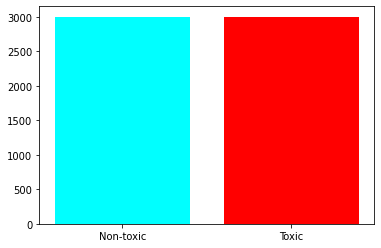

In [82]:
distributionOfClasses.toxic=['Non-toxic','Toxic']
plt.bar(distributionOfClasses.toxic, distributionOfClasses.comment_text, color=['cyan','red'])

In [83]:
distributionOfLength=pd.DataFrame()
distributionOfLength['comment_text'] = trainData['comment_text'].apply(len)
distributionOfLength['toxic'] = trainData.toxic
distributionOfLength.head()

,comment_text,toxic
0,83,1
1,118,1
2,107,1
3,112,1
4,23,1


{'bodies': [<matplotlib.collections.PolyCollection at 0x7fcdb8421c90>,
 'cbars': <matplotlib.collections.LineCollection at 0x7fcdb842c650>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7fcdb842c1d0>,
 'cmeans': <matplotlib.collections.LineCollection at 0x7fcdb8421ad0>,
 'cmedians': <matplotlib.collections.LineCollection at 0x7fcdb842c9d0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7fcdb8421dd0>}

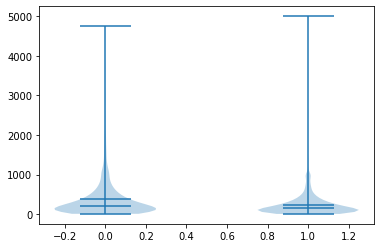

In [84]:
plt.violinplot(
    [distributionOfLength[distributionOfLength.toxic==0].comment_text.values ,distributionOfLength[distributionOfLength.toxic==1].comment_text.values]
    , [0,1],
    showmeans=True, showextrema=True, showmedians=True)

In [134]:
from wordcloud import WordCloud

import random
def NegativeColorWordCloud(word, font_size, position, orientation, random_state=None, **kwargs):
    return f'hsl({random.randint(0, 42)}, {random.randint(80, 100)}%, 50%)'

def PositiveColorWordCloud(word, font_size, position, orientation, random_state=None, **kwargs):
    return f'hsl({random.randint(97, 161)}, {random.randint(80, 100)}%, 50%)'

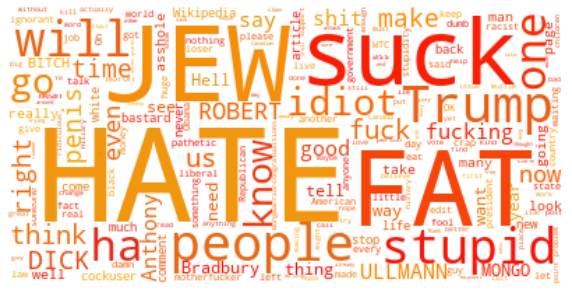

In [136]:
wordCloud = WordCloud(collocations = False, background_color = 'white').generate(" ".join(trainData[trainData['toxic']==1].comment_text))

wordCloud.recolor(color_func=NegativeColorWordCloud)

plt.figure(figsize=(10,12))
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()

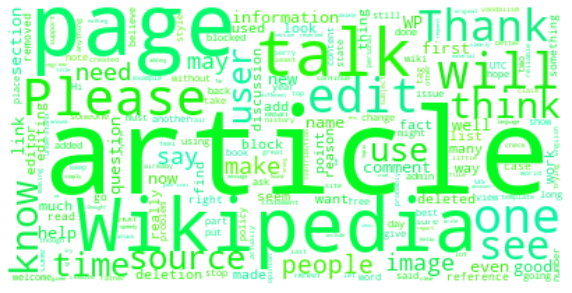

In [138]:
wordCloud = WordCloud(collocations = False, background_color = 'white').generate(" ".join(trainData[trainData['toxic']==0].comment_text))

wordCloud.recolor(color_func=PositiveColorWordCloud)

plt.figure(figsize=(10,12))
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Data Cleaning

BERT was trained using stop words and without stemming and lemmatiation. It is prefered to avoid passing text through these techniques.

In [86]:
# Left text case sensitive.
def RemoveLinks(text):
  return re.sub('^(http|https)://\S+|www\.\S+','',text)

def RemovePunctuation(text):
  text = re.sub('<.*?>+','',text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '',text)
  return re.sub('\n','',text)

def RemoveNumbers(text):
  return re.sub('\w*\d\w*','',text)

In [87]:
trainData['cleaned_text'] = trainData['comment_text'].apply(str).apply(RemoveLinks)
trainData['cleaned_text'] = trainData['comment_text'].apply(str).apply(RemovePunctuation)
trainData['cleaned_text'] = trainData['comment_text'].apply(str).apply(RemoveNumbers)


testData['cleaned_text'] = testData['comment_text'].apply(str).apply(RemoveLinks)
testData['cleaned_text'] = testData['comment_text'].apply(str).apply(RemovePunctuation)
testData['cleaned_text'] = testData['comment_text'].apply(str).apply(RemoveNumbers)

trainData.head()

,comment_text,toxic,cleaned_text
0,"Wasn't me, asshole. Check your fucking IP's b...",1,"Wasn't me, asshole. Check your fucking IP's b..."
1,Stupid law. Why does Quebec always have to ca...,1,Stupid law. Why does Quebec always have to ca...
2,after qualifying for the Wimbledon main draw -...,1,after qualifying for the Wimbledon main draw -...
3,THE QUESTION IS NOT WHETHER IT'S ART OR PORNOG...,1,THE QUESTION IS NOT WHETHER IT'S ART OR PORNOG...
4,fuck you white trash!!!,1,fuck you white trash!!!


# Tokenizer

In [88]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')

## Example of encoding

The function *encode_plus* from the *tokenizer* performs:


1.   Sentece tokenization.
2.   Addition of [CLS] and [SEP] special tokens.
3.   Map tokens to their IDs.
4.   Pad or Trucante of sentence.
5.   Create the attention masks which explicitly differentiate real tokens from [PAD] tokens.



In [89]:
for key, values in tokenizer.encode_plus(trainData.cleaned_text[0]).items():
  print(key, values)

input_ids [101, 23720, 112, 189, 1143, 117, 27877, 119, 23114, 1240, 8750, 14274, 112, 188, 1196, 1128, 1301, 4598, 1228, 1240, 1779, 119, 102]
token_type_ids [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
attention_mask [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


List of returner values:
* input_ids – List of token ids to be fed to a model. The input ids are often the only required parameters to be passes to the model as input. They are token indices, numerical representation of tokens nbuilding the sequences that will be used as input by the model.

* token_type_ids – List of token type ids to be fed to a model (when return_token_type_ids=True or if “token_type_ids” is in self.model_input_names).

* attention_mask – List of indices specifying which tokens should be attended to by the model (when return_attention_mask=True or if “attention_mask” is in self.model_input_names).



Text(0, 0.5, 'Freq')

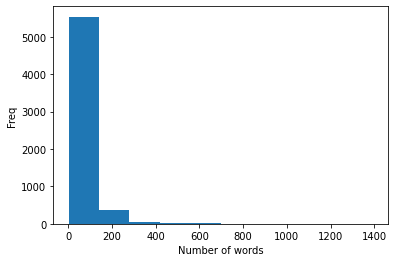

In [90]:
lengthSentences = trainData['comment_text'].apply(str).apply(lambda comment_text: len(comment_text.split(' ')))
plt.hist(lengthSentences,10)
plt.xlabel('Number of words')
plt.ylabel('Freq')

As we can see, 300 features should be enough

In [92]:
MAXFEATURES=300

# Pytorch

## Definition of the dataset

In [93]:
class ToxicComments(Dataset):
  def __init__(self, commentsText, labels, tokenizer, maxFeatures):
    self.commentsText = commentsText
    self.labels = labels
    self.tokenizer = tokenizer
    self.maxFeatures = maxFeatures

  def __len__(self):
    return len(self.commentsText)

  def __getitem__(self, id):
    text = self.commentsText[id]
    text = self.tokenizer.encode_plus(
          text, 
          add_special_tokens=True,
          max_length = self.maxFeatures,
          pad_to_max_length = True,
          truncation = True,
          return_attention_mask = True
        )
    ids = torch.tensor(text['input_ids'], dtype=torch.long)
    mask = torch.tensor(text['attention_mask'], dtype=torch.float)
    tokenTypes = torch.tensor(text['token_type_ids'], dtype=torch.long)
    label = torch.tensor(self.labels[id], dtype=torch.int64)

    return {
        'label':label,
        'input_ids':ids,
        'attention_masks':mask,
        'token_type_ids': tokenTypes
    }

In [94]:
trainDataset = ToxicComments(trainData['cleaned_text'].values, trainData['toxic'].values, tokenizer, MAXFEATURES)
testDataset = ToxicComments(testData['cleaned_text'].values, testData['toxic'].values, tokenizer, MAXFEATURES)

In [95]:
trainLoader = DataLoader(trainDataset, batch_size=8, pin_memory=True, num_workers=4, shuffle=True)
testLoader = DataLoader(testDataset, batch_size=8, pin_memory=True, num_workers=4, shuffle=True)

In [96]:
for dataBatch in trainLoader:
  print(dataBatch['label'])
  print(dataBatch['input_ids'])
  print(dataBatch['attention_masks'])
  print(dataBatch['token_type_ids'])
  break

tensor([1, 1, 0, 0, 0, 1, 1, 0])
tensor([[ 101,  146, 1221,  ...,    0,    0,    0],
        [ 101,  146,  787,  ...,    0,    0,    0],
        [ 101,  107,  143,  ...,    0,    0,    0],
        ...,
        [ 101, 1337, 1110,  ...,    0,    0,    0],
        [ 101,  140,  158,  ...,    0,    0,    0],
        [ 101,  107,  117,  ...,    0,    0,    0]])
tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


# BERT Modeling

In [97]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [98]:
model = transformers.BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=2)
model.to(DEVICE)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Testing Before Training

In [99]:
with torch.no_grad():
  model.eval()
  for batchData in trainLoader:

    ids = batchData['input_ids'].to(DEVICE)
    mask = batchData['attention_masks'].to(DEVICE)
    output = model(ids, mask)

    prediction = F.softmax(output['logits'], dim=1) # Output also contains the loss, but in the validation it has a value of None

    print(prediction)
    break

tensor([[0.5927, 0.4073],
        [0.5815, 0.4185],
        [0.5813, 0.4187],
        [0.5645, 0.4355],
        [0.6079, 0.3921],
        [0.5479, 0.4521],
        [0.6336, 0.3664],
        [0.5700, 0.4300]], device='cuda:0')


In [100]:
print(torch.max(prediction, dim=1))

torch.return_types.max(
values=tensor([0.5927, 0.5815, 0.5813, 0.5645, 0.6079, 0.5479, 0.6336, 0.5700],
       device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))


# Training

Hyperparams

In [102]:
EPOCHS=2
LEARNINGRATE=2e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8, weight_decay=1e-3)
totalSteps = len(trainLoader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=totalSteps)
# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNINGRATE)

# lossFn = nn.CrossEntropyLoss().to(DEVICE)
# lossFn = F.cross_entropy()

## Training and testing function

In [104]:
from tqdm import tqdm

def Train(model, data, optimizer, scheduler):
  print(f'Starting training...')
  model.train()
  totalEpochLoss=0
  totalEpochAccuracy=0

  # for batchData in data:
  for i, batchData in tqdm(enumerate(data), total = len(data)):
    labels = batchData['label'].to(DEVICE)
    input_ids = batchData['input_ids'].to(DEVICE)
    attention_masks = batchData['attention_masks'].to(DEVICE)
    token_type_ids = batchData['token_type_ids'].to(DEVICE)

    model.zero_grad()

    # You can also input the labels, the regression loss is computer (Mean-Squared loss) if num. labels is 1. Otherwise, Cross-Entropy if num. labels > 1.
    output = model(input_ids=input_ids, attention_mask=attention_masks)
    # labels=labels\
    # loss, logits, hidden_states_output, attention_mask_output = output

    # The cross entropy loss function expects unnormalized scored.
    loss = F.cross_entropy(output['logits'], labels)
    loss.backward()
    # Clip the norm of the gradients to 1.0 to prevent exploding gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()

    prediction = F.softmax(output['logits'], dim=1)
    totalEpochLoss+=loss.item()
    totalEpochAccuracy+=(
        torch.argmax(prediction, dim=1)==labels
        ).sum().item()/len(labels)
  
  return totalEpochLoss/len(data), totalEpochAccuracy/len(data)


def Test(model, data):
    print(f'\nStarting testing...')
    testLoss=0
    testAccuracy=0

    model.eval()
    with torch.no_grad():
      # for batchData in data:
      for i, batchData in tqdm(enumerate(data), total = len(data)):
        labels = batchData['label'].to(DEVICE)
        input_ids = batchData['input_ids'].to(DEVICE)
        attention_masks = batchData['attention_masks'].to(DEVICE)
        token_type_ids = batchData['token_type_ids'].to(DEVICE)

        output = model(input_ids=input_ids, attention_mask=attention_masks)

        loss = F.cross_entropy(output['logits'], labels)
        testLoss+=loss.item()

        prediction = F.softmax(output['logits'], dim=1)

        testAccuracy+=(
            torch.argmax(prediction, dim=1)==labels
            ).sum().item()/len(labels)
      
      return testLoss/len(data), testAccuracy/len(data)

## Run

In [105]:
import warnings
warnings.filterwarnings('ignore')

for epoch in range(EPOCHS):
  print(f'\n\nEpoch {epoch}')

  trainLoss, trainAcc = Train(model, trainLoader, optimizer, scheduler)

  testLoss, testAcc = Test(model, testLoader)
  print(f'\nEpoch [{epoch}] Training loss: {trainLoss}, accuracy: {trainAcc}')
  print(f'Epoch [{epoch}] Testing loss: {testLoss}, accuracy: {testAcc}')



Epoch 0
Starting training...


100%|██████████| 750/750 [11:36<00:00,  1.08it/s]


Starting testing...



100%|██████████| 250/250 [01:23<00:00,  2.98it/s]


Epoch [0] Training loss: 0.27975893280189484, accuracy: 0.909
Epoch [0] Testing loss: 0.20890582071151584, accuracy: 0.9395


Epoch 1
Starting training...



100%|██████████| 750/750 [11:36<00:00,  1.08it/s]


Starting testing...



100%|██████████| 250/250 [01:23<00:00,  2.98it/s]


Epoch [1] Training loss: 0.1334682893085604, accuracy: 0.9653333333333334
Epoch [1] Testing loss: 0.2445846535200253, accuracy: 0.937


# Results

In [106]:
from sklearn.metrics import confusion_matrix, classification_report

predictions = torch.empty((1,), dtype=torch.uint8 ,device=DEVICE)
ground = torch.empty((1,), dtype=torch.uint8 ,device=DEVICE)
with torch.no_grad():
  model.eval()
  for i, batchData in tqdm(enumerate(testLoader), total = len(testLoader)):
      labels = batchData['label'].to(DEVICE)
      input_ids = batchData['input_ids'].to(DEVICE)
      attention_masks = batchData['attention_masks'].to(DEVICE)
      token_type_ids = batchData['token_type_ids'].to(DEVICE)

      output = model(input_ids=input_ids, attention_mask=attention_masks)

      pred = F.softmax(output['logits'], dim=1)

      predictions = torch.cat((
          predictions, torch.argmax(pred, dim=1)
          ))
      ground = torch.cat((ground, labels))

100%|██████████| 250/250 [01:22<00:00,  3.01it/s]


In [130]:
resultsDf = pd.DataFrame(np.array([
                       ground.cpu().numpy(),
                       predictions.cpu().numpy()
]).T, columns=['ground','predictions'])

confusion_matrix(resultsDf['ground'][1:], resultsDf['predictions'][1:])

array([[922,  78],
       [ 48, 952]])

In [129]:
print(classification_report(resultsDf['ground'][1:], resultsDf['predictions'][1:]))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94      1000
           1       0.92      0.95      0.94      1000

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000

